# Verify WFA - Mutiple Linear Regression

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades

In [3]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from util.Save_result_return import save_to_csv

plt.style.use("seaborn-v0_8")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [5]:
from backtesting import Strategy

In [6]:
import warnings
warnings.simplefilter("ignore")

## Getting the Data

In [7]:
XAUUSD = load_data()

In [8]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [9]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


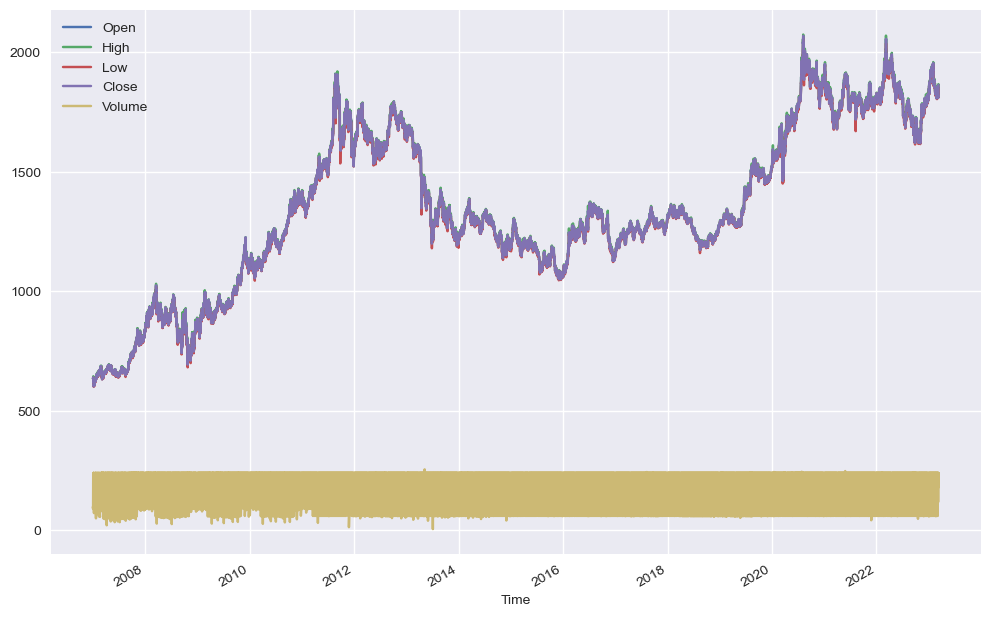

In [10]:
XAUUSD['H4'].plot(figsize=(12, 8))
plt.show()

## ML

### Class and Strategy ML

In [11]:
class Mutiple_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [12]:
mainFolder = 'Machine_Learning'
strategy = Mutiple_Regression
strategyName = 'Mutiple_Regression'
account_size = 1000
folder_ML_Strategy = 'Mutiple_Linear_Regression'
subFolder = 'Optimization'

In [74]:
class ML_Regression():

    def __init__(self, data, strategy, start_train,  end_train,  TF, window_size, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.end_train = end_train
        self.TF = TF
        self.window_size = window_size
        self.account_size = account_size
        self.data_train = None
        self.results = None
        self.model = None

    def Prepare(self, lags=1000):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'] / data['Close'].shift(1))
        data.dropna(inplace=True)
       
        cols = []
        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)
        data['pred'] = 0


        for i in range(self.window_size, len(data)):
            rolling_window_data = data.iloc[i - self.window_size :i ]

            lm = LinearRegression(fit_intercept=True)
            lm.fit(rolling_window_data[cols],
                   rolling_window_data['returns'])

            # Predict for the next data point
            pred_value = lm.predict(
                np.array(data[cols].iloc[i]).reshape(1, -1))
            data.at[data.index[i], 'pred'] = np.sign(pred_value[0])

        self.model = lm
        self.data_train = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        account_size = self.account_size
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100)
        result = backtest.run()
        return result

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)

        return result_train

## Check TF D1

In [29]:
XAUUSD['D1']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604
2007-01-02,635.791,640.802,635.286,639.143,1282
2007-01-03,639.029,644.663,624.634,626.602,1302
2007-01-04,626.699,630.352,619.600,622.533,1365
2007-01-05,622.268,625.768,601.591,606.841,1284
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


In [50]:
start_train = '2007'
end_train = '2023'
account_size = 1000
TF = 'D1'

### Window size 1 year

In [69]:
data = XAUUSD['D1']
window_size = 252
WFA = '1y'

In [70]:
ml = ML_Regression(data, strategy, start_train, end_train,
                   TF, window_size, account_size)

In [59]:
data["returns"] = np.log(data['Close'] / data['Close'].shift(1))

In [62]:
data.loc['2011-01-01': '2011-01-06']

,Open,High,Low,Close,Volume,returns
Time,,,,,,
2011-01-02,1419.100,1420.690,1416.247,1416.247,89,-0.001858
2011-01-03,1416.862,1423.774,1412.631,1414.592,1415,-0.001169
2011-01-04,1414.745,1417.192,1374.672,1384.025,1410,-0.021845
2011-01-05,1384.003,1384.755,1363.819,1375.515,1411,-0.006168
2011-01-06,1375.377,1379.793,1364.434,1370.799,1416,-0.003434


In [71]:
test = ml.Run()

In [73]:
test

Start                     2010-03-14 00:00:00
End                       2023-03-09 00:00:00
Duration                   4743 days 00:00:00
Exposure Time [%]                   93.739173
Equity Final [$]                      644.763
Equity Peak [$]                      1209.984
Return [%]                           -35.5237
Buy & Hold Return [%]               65.871461
Return (Ann.) [%]                   -2.699732
Volatility (Ann.) [%]               41.600807
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -93.615453
Avg. Drawdown [%]                  -10.994355
Max. Drawdown Duration     3095 days 00:00:00
Avg. Drawdown Duration      278 days 00:00:00
# Trades                                 1947
Win Rate [%]                        45.095018
Best Trade [%]                       7.442469
Worst Trade [%]                     -5.158484
Avg. Trade [%]                    

In [39]:
test['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-1,253,258,1416.862,1369.000,47.862,0.033780,2011-01-03,2011-01-09,6 days
1,1,258,262,1369.000,1386.543,17.543,0.012814,2011-01-09,2011-01-13,4 days
2,-1,262,264,1386.543,1360.650,25.893,0.018675,2011-01-13,2011-01-16,3 days
3,1,264,265,1360.650,1363.780,3.130,0.002300,2011-01-16,2011-01-17,1 days
4,-1,265,266,1363.780,1360.831,2.949,0.002162,2011-01-17,2011-01-18,1 days
...,...,...,...,...,...,...,...,...,...,...
1953,1,4025,4026,1838.585,1841.655,3.070,0.001670,2023-02-20,2023-02-21,1 days
1954,-1,4026,4030,1841.655,1810.758,30.897,0.016777,2023-02-21,2023-02-26,5 days
1955,1,4030,4036,1810.758,1854.644,43.886,0.024236,2023-02-26,2023-03-05,7 days
1956,-1,4036,4039,1854.644,1813.855,40.789,0.021993,2023-03-05,2023-03-08,3 days


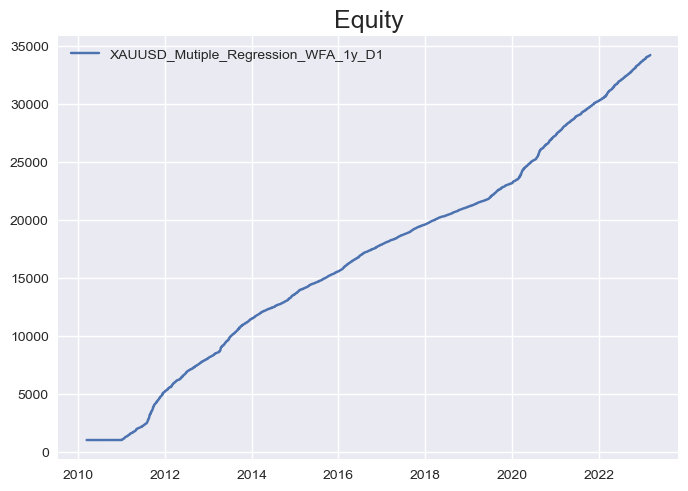

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_{strategyName}_WFA_{WFA}_{TF}', account_size)

In [103]:
test

Start                     2007-04-29 00:00:00
End                       2023-03-09 00:00:00
Duration                   5793 days 00:00:00
Exposure Time [%]                   94.879579
Equity Final [$]                    27659.059
Equity Peak [$]                     27659.059
Return [%]                          2665.9059
Buy & Hold Return [%]              169.405765
Return (Ann.) [%]                   18.450346
Volatility (Ann.) [%]                4.141756
Sharpe Ratio                         4.454716
Sortino Ratio                       19.384499
Calmar Ratio                        11.277953
Max. Drawdown [%]                   -1.635966
Avg. Drawdown [%]                   -0.092972
Max. Drawdown Duration       73 days 00:00:00
Avg. Drawdown Duration        5 days 00:00:00
# Trades                                 2360
Win Rate [%]                        73.898305
Best Trade [%]                      11.730028
Worst Trade [%]                     -3.043261
Avg. Trade [%]                    